<a href="https://colab.research.google.com/github/kleeresearch/Python/blob/master/20250430_carbon_neutrality_dataupdate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Update**
- update data from the IEA (2020 data to 2021 data)
- add data function and clean up codes
- results are same


# Carbon Neutrality Paper

* Writer: Kyungmin Lee
* Date: 2023/08/31




# Data Explanation
IEA

data source:

https://www.iea.org/data-and-statistics/data-product/greenhouse-gas-emissions-from-energy-highlights#data-sets


- GHG highlights excel sheets
- CO2 emissions and drivers (Kaya decomposition)


IEA data

[https://www.iea.org/data-and-statistics/data-product/greenhouse-gas-emissions-from-energy-highlights#data-sets](https://www.iea.org/data-and-statistics/data-product/greenhouse-gas-emissions-from-energy-highlights#data-sets)

# Data Manipulation

In [ ]:
from matplotlib.widgets import Widget

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# -- Installing proper packages to be able to read in the dataset that weren't installed
!pip install pandas
!pip install --upgrade xlrd
!pip install tslearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 21.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from google.colab import files

from sklearn.cluster import KMeans
from sklearn import datasets
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from tslearn.clustering import TimeSeriesKMeans
import collections

Please download "GHGHighlights" data set from this link: https://www.iea.org/data-and-statistics/data-product/greenhouse-gas-emissions-from-energy-highlights#data-sets

Name it as "GHGHighlights_YEARMON" (i.e. GHGHighlights_202301.xls)

Load data

In [ ]:
# -- Data loading

# - set "KAYA" sheet and make header as YEAR
#data = pd.read_excel("/content/drive/MyDrive/1. Research Experience/Paper_Scenario/dataset/final/GHGHighlights_202301.xls", 'KAYA', header=3)
data = pd.read_excel("/content/drive/MyDrive/1. Research Experience/Paper_Scenario/dataset/final/GHGHighlights_202301.xlsx","KAYA", header=3)
# - drop columns
data = data.drop(['Unnamed: 53', 'Unnamed: 54', 'Unnamed: 55', 'Unnamed: 56', 'Unnamed: 57', 'Unnamed: 58'], axis=1)
# - load data
data

,index (reference year = 100),Unnamed: 1,1971,1972,1973,1974,1975,1976,1977,1978,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,World,CO2 emissions,60.006,62.848,66.449,66.311,66.559,70.105,72.482,74.646,...,136.838,139.468,139.755,139.162,139.375,141.637,145.016,144.706,136.418,144.295
2,NaN,Population,61.359,62.594,63.855,65.092,66.297,67.487,68.671,69.873,...,116.199,117.615,119.035,120.446,121.854,123.249,124.609,125.938,127.192,128.313
3,NaN,GDP per population (GDP per capita),64.058,66.239,69.407,70.121,70.251,72.974,74.893,76.533,...,132.358,135.015,137.942,140.83,143.584,147.191,150.796,153.318,147.289,155.05
4,NaN,Energy intensity (TES/GDP),139.674,138.875,136.909,133.735,132.019,131.695,130.613,130.483,...,85.651,84.157,82.434,79.921,78.188,77.028,76.174,75.129,74.559,73.998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,NaN,Carbon intensity: ESCII (CO2/TES),92.304,92.74,92.369,96.559,97.738,96.988,97.34,94.787,...,100.469,97.386,95.015,95.983,97.907,95.756,94.902,92.854,89.448,89.828
1112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1113,NaN,NaN,"The original version of this file, as publishe...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1114,NaN,NaN,\nYou are permitted to use the data in this fi...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#data['index (reference year = 100)'].dropna().to_list()

In [ ]:
def country(cname):
  stcol = data[data['index (reference year = 100)'] == cname].index[0]
  encol =data[data['index (reference year = 100)'] == cname].index[0]+4
  country = data.loc[stcol:encol].T.reset_index().drop(index=0)
  country = country.rename(columns=country.iloc[0]).drop(index=1).rename(columns={"Unnamed: 1": "Year"}).set_index(keys='Year')
  return country

In [ ]:
# Data manipulation

world = country('World')

korea = country('Korea') #1 -
japan = country('Japan') #2 -
hungary = country('Hungary') #3 -

romania = country('Romania') #4

canada = country('Canada') #5 -
ireland = country('Ireland') #6 -
uk = country('United Kingdom') #7 -
spain = country('Spain') #8 -

sweden = country('Sweden') #9 -
nz = country('New Zealand') #10-
france = country('France') #11 -
germany = country('Germany') #12 -
denmark = country('Denmark') #13 -
chile = country('Chile') #14 -

# newly added
luxembourg = country('Luxembourg') #15 -
portugal = country('Portugal') #16 -
australia = country('Australia') #17-
nigeria = country('Nigeria') #18 -
finland = country('Finland') #19 -
greece = country('Greece') #20 -
iceland = country('Iceland') #21 -
colombia = country('Colombia') #22 -
switzerland = country('Switzerland') #23 -
gabon = country('Gabon') #24 -
austria = country('Austria') #25 -
australia = country('Australia') #26 -

# EU
eu = country('European Union - 27')
eu = eu.reset_index()
eu = eu[eu["Year"] >= 1990].set_index(keys="Year")

# N/A: Fiji -, Liechtenstein -, Maldives-

In [ ]:
legcountry = [world, korea, japan, hungary, romania, canada,ireland, uk, spain, sweden, nz,france, germany, denmark, chile,
              luxembourg,portugal, australia, nigeria, finland, greece,iceland, colombia, switzerland, gabon, austria, australia]

legcountry_title = ['World', 'Korea','Japan','Hungary','Romania','Canada','Ireland','United Kingdom','Spain','Sweden','New Zealand','France','Germany','Denmark','Chile','Luxembourg',
                    'Portugal','Australia','Nigeria','Finland','Greece','Iceland','Colombia','Switzerland','Gabon','Austria','Australia']

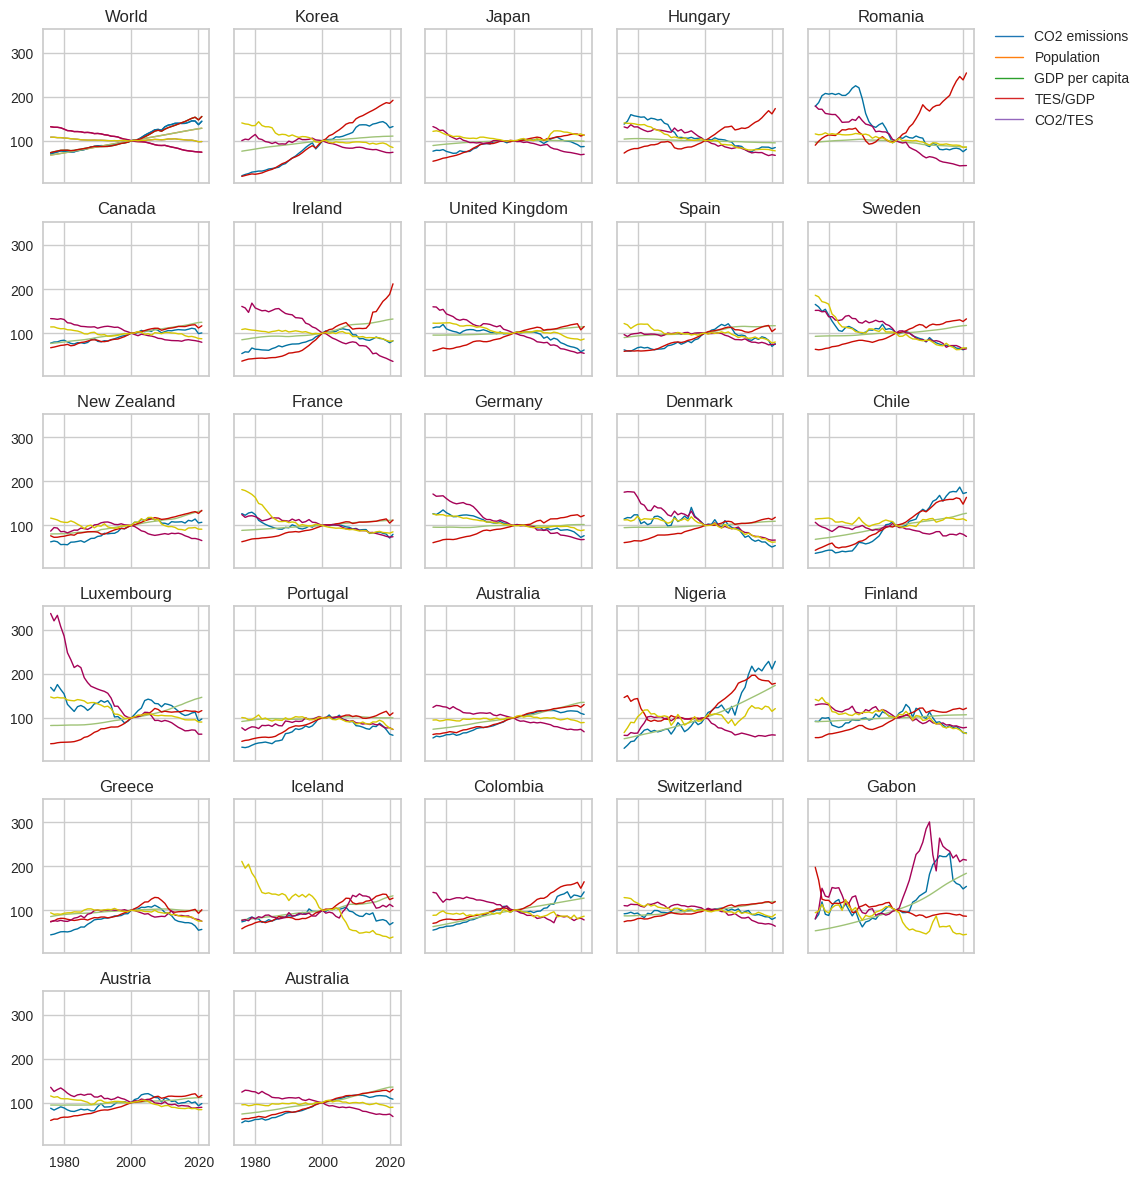

In [ ]:
year = 1976
r, c = 6,5

# -- Plotting data by countries
fig, ax = plt.subplots(r,c, figsize=(10,13), sharex=True, sharey=True)

ax[0,0].plot(world["CO2 emissions"].loc[year:], color="tab:blue", label="CO2 emissions", lw=1)
ax[0,0].plot(world["Population"].loc[year:], c ="tab:orange", label="Population", lw=1)
ax[0,0].plot(world["GDP per population (GDP per capita)"].loc[year:], c="tab:green", label="GDP per capita", lw=1)
ax[0,0].plot(world["Energy intensity (TES/GDP)"].loc[year:], c="tab:red", label="TES/GDP", lw=1)
ax[0,0].plot(world["Carbon intensity: ESCII (CO2/TES)"].loc[year:], c="tab:purple", label="CO2/TES", lw=1)

for i in range(len(legcountry)):
  ax[i//c, i%c].plot(legcountry[i].loc[year:], lw=1)
  ax[i//c, i%c].set_title(legcountry_title[i])
#fig.suptitle("Kaya Decomposition of CO2 Emissions and Drivers (Reference year = 2000)", fontsize=20, weight="bold")

ax[5,2].axis('off')
ax[5,3].axis('off')
ax[5,4].axis('off')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.legend(loc='upper right', bbox_to_anchor=(1.15, 0.93), ncol=1, fancybox=True, shadow=True)

plt.margins(x=0)

fig.savefig("countries.png")
plt.show()

In [ ]:
#files.download("countries.png")

In [ ]:
#files.download("kaya_countries.png")

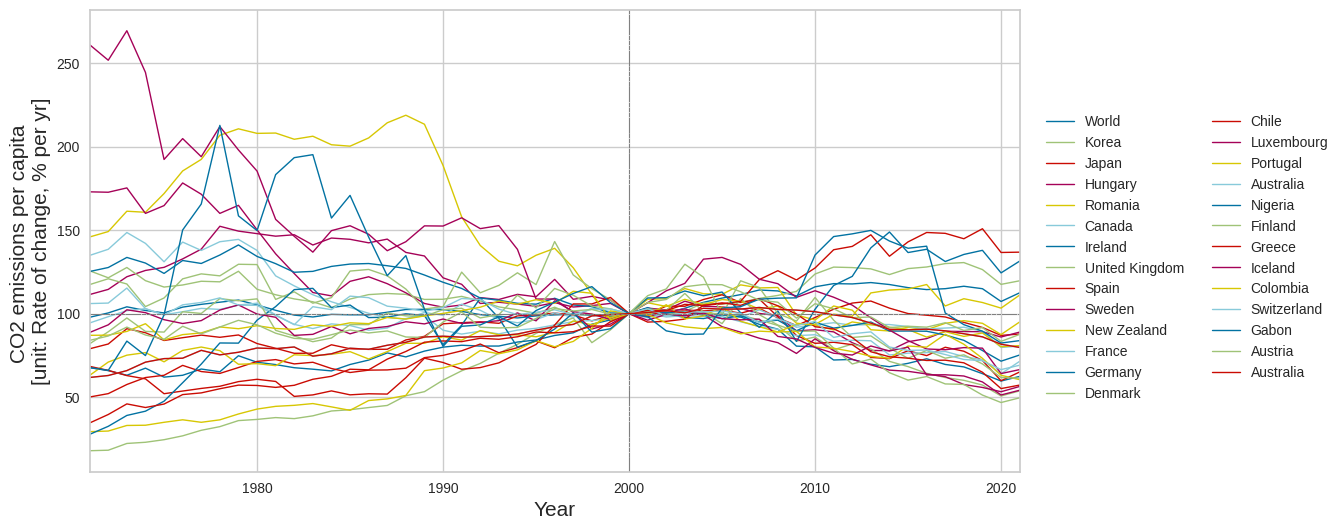

In [ ]:
# CO2 emissions per capita
def co2capita(country):
  x = pd.DataFrame(country["CO2 emissions"] / country["Population"] * 100)
  return x

# X-axis
iea_year = world.index.to_list()

# Plot
fig, ax = plt.subplots(figsize=(12,6))
for i in range(len(legcountry)):
  ax.plot(co2capita(legcountry[i]), label=legcountry_title[i], lw=1)
  ax.axhline(100, 0, 1, color="gray", linestyle="--", linewidth=0.7)
  ax.axvline(2000, 0, 1, color="gray", linestyle="--", linewidth=0.7)
  ax.set_xticks(iea_year, minor=True)
  #ax.set_xticklabels(year, rotation=45)
  ax.legend(loc='upper center', bbox_to_anchor=(1.18, 0.8), ncol=2, fancybox=True, shadow=True)
  #ax.set_title("CO2 emissions per capita of the Countries with Legally Binding Agreements (Reference year=2000)", fontsize=20, weight="bold")
  ax.set_ylabel("CO2 emissions per capita \n[unit: Rate of change, % per yr]", fontsize=15)
  ax.set_xlabel("Year", fontsize=15)
plt.margins(x=0)
plt.show()
fig.savefig("co2capita_allc.png")

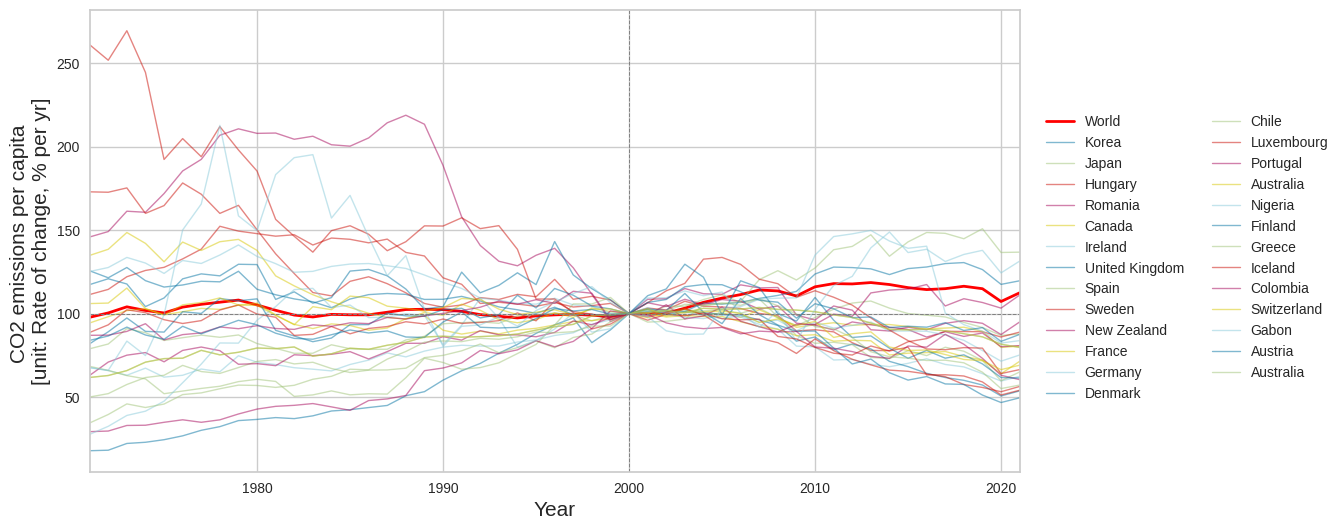

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(12,6))

for i in range(len(legcountry)):
    if legcountry_title[i] == "World":  # Highlight the "World" line
        ax.plot(co2capita(legcountry[i]), label=legcountry_title[i], color="red", lw=2, alpha=1)
    else:
        ax.plot(co2capita(legcountry[i]), label=legcountry_title[i], lw=1, alpha=0.5)

ax.axhline(100, 0, 1, color="gray", linestyle="--", linewidth=0.7)
ax.axvline(2000, 0, 1, color="gray", linestyle="--", linewidth=0.7)

ax.set_xticks(iea_year, minor=True)
ax.legend(loc='upper center', bbox_to_anchor=(1.18, 0.8), ncol=2, fancybox=True, shadow=True)

ax.set_ylabel("CO2 emissions per capita \n[unit: Rate of change, % per yr]", fontsize=15)
ax.set_xlabel("Year", fontsize=15)

plt.margins(x=0)
plt.show()
#fig.savefig("co2capita_allc.png")

In [ ]:
#files.download("co2capita_allc.png")

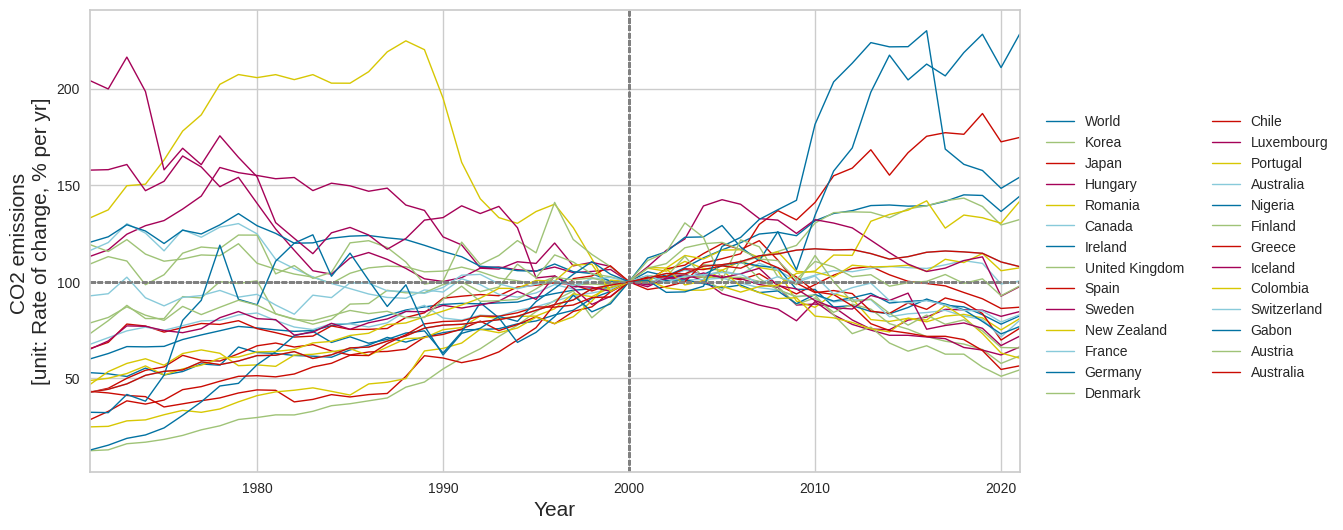

In [ ]:
# (1) CO2 emissions

def co2(country):
  x = pd.DataFrame(country["CO2 emissions"])
  return x

# plot
fig, ax = plt.subplots(figsize=(12,6))
for i in range(len(legcountry)):
  ax.plot(co2(legcountry[i]), label=legcountry_title[i], lw=1)
  ax.axhline(100, 0, 1, color="gray", linestyle="--", linewidth=1)
  ax.axvline(2000, 0, 1, color="gray", linestyle="--", linewidth=1)
  ax.set_xticks(iea_year, minor=True)
  #ax.set_xticklabels(year, rotation=45)
  ax.legend(loc='upper center', bbox_to_anchor=(1.18, 0.8), ncol=2, fancybox=True, shadow=True)
  #ax.set_title("CO2 Emissions of the Countries with Legally Binding Agreements (Reference year=2000)", fontsize=20, weight="bold")
  ax.set_ylabel("CO2 emissions \n[unit: Rate of change, % per yr]", fontsize=15, )
  ax.set_xlabel("Year", fontsize=15)
plt.margins(x=0)
plt.show()
#fig.savefig("Fig1.png")

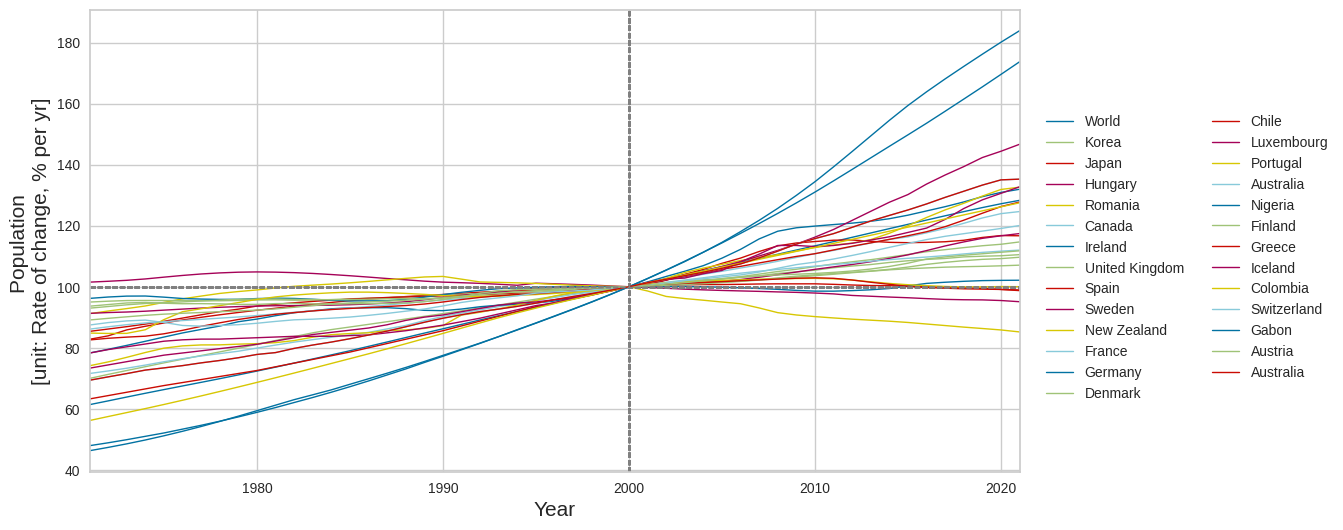

In [ ]:
# (2) Population

def pop(country):
  x = pd.DataFrame(country["Population"])
  return x

fig, ax = plt.subplots(figsize=(12,6))
for i in range(len(legcountry)):
  ax.plot(pop(legcountry[i]), label=legcountry_title[i], lw=1)
  ax.axhline(100, 0, 1, color="gray", linestyle="--", linewidth=1)
  ax.axvline(2000, 0, 1, color="gray", linestyle="--", linewidth=1)
  ax.set_xticks(iea_year, minor=True)
  #ax.set_xticklabels(year, rotation=45)
  ax.legend(loc='upper center', bbox_to_anchor=(1.18, 0.8), ncol=2, fancybox=True, shadow=True)
  #ax.set_title("Population of the Countries with Legally Binding Agreements (Reference year=2000)", fontsize=20, weight="bold")
  ax.set_ylabel("Population \n[unit: Rate of change, % per yr]", fontsize=15)
  ax.set_xlabel("Year", fontsize=15)
plt.margins(x=0)
plt.show()
#fig.savefig("Fig2.png")

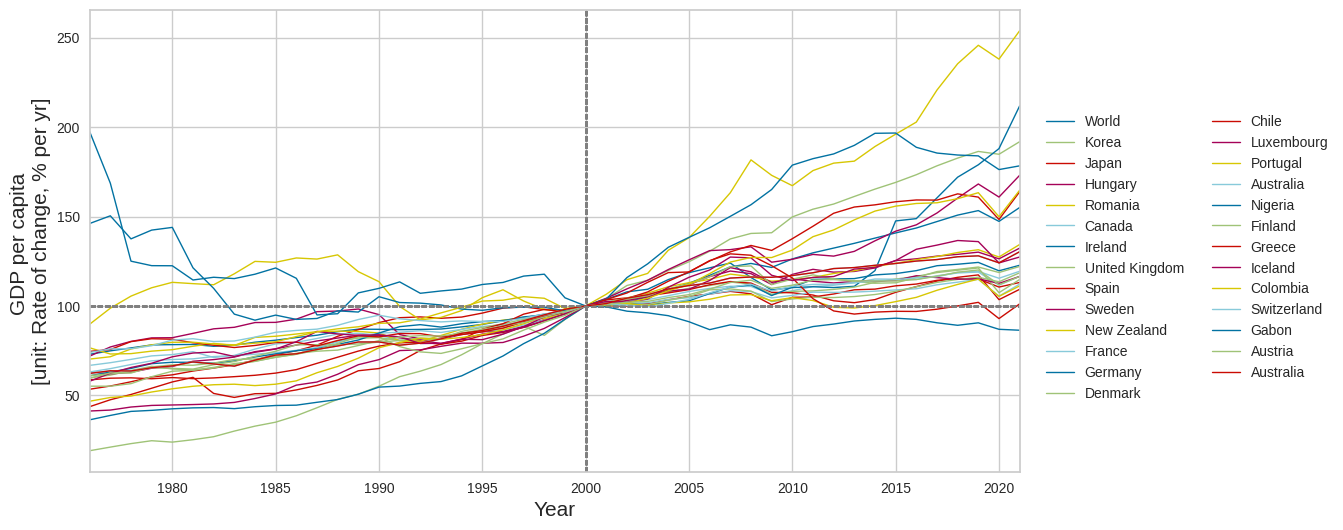

In [ ]:
year = 1976

# (3) GDP per population (GDP per capita)

def gdpcapita(country):
  x = pd.DataFrame(country["GDP per population (GDP per capita)"], columns=["GDP per population (GDP per capita)"])
  return x

fig, ax = plt.subplots(figsize=(12,6))
for i in range(len(legcountry)):
  ax.plot(gdpcapita(legcountry[i].loc[year:]), label=legcountry_title[i], lw=1)
  ax.axhline(100, 0, 1, color="gray", linestyle="--", linewidth=1)
  ax.axvline(2000, 0, 1, color="gray", linestyle="--", linewidth=1)
  ax.set_xticks(iea_year[year:], minor=True)
  #ax.set_xticklabels(year, rotation=45)
  ax.legend(loc='upper center', bbox_to_anchor=(1.18, 0.8), ncol=2, fancybox=True, shadow=True)
  #ax.set_title("GDP per capita of the Countries with Legally Binding Agreements (Reference year=2000)", fontsize=20, weight="bold")
  ax.set_ylabel("GDP per capita \n[unit: Rate of change, % per yr]", fontsize=15)
  ax.set_xlabel("Year", fontsize=15)
plt.margins(x=0)
plt.show()
fig.savefig("gdpca_allc.png")
#files.download("gdpca_allc.png")

In [ ]:
# # Plot
# fig, ax = plt.subplots(figsize=(12,6))

# for i in range(len(legcountry)):
#     if legcountry_title[i] == "World":  # Highlight the "World" line
#         ax.plot(gdpcapita(legcountry[i]), label=legcountry_title[i], color="red", lw=2, alpha=1)
#     else:
#         ax.plot(gdpcapita(legcountry[i]), label=legcountry_title[i], lw=1, alpha=0.5)

# ax.axhline(100, 0, 1, color="gray", linestyle="--", linewidth=0.7)
# ax.axvline(2000, 0, 1, color="gray", linestyle="--", linewidth=0.7)

# ax.set_xticks(iea_year, minor=True)
# ax.legend(loc='upper center', bbox_to_anchor=(1.18, 0.8), ncol=2, fancybox=True, shadow=True)

# ax.set_ylabel("GDP per capita \n[unit: Rate of change, % per yr]", fontsize=15)
# ax.set_xlabel("Year", fontsize=15)

# plt.margins(x=0)
# plt.show()
# #fig.savefig("co2capita_allc.png")

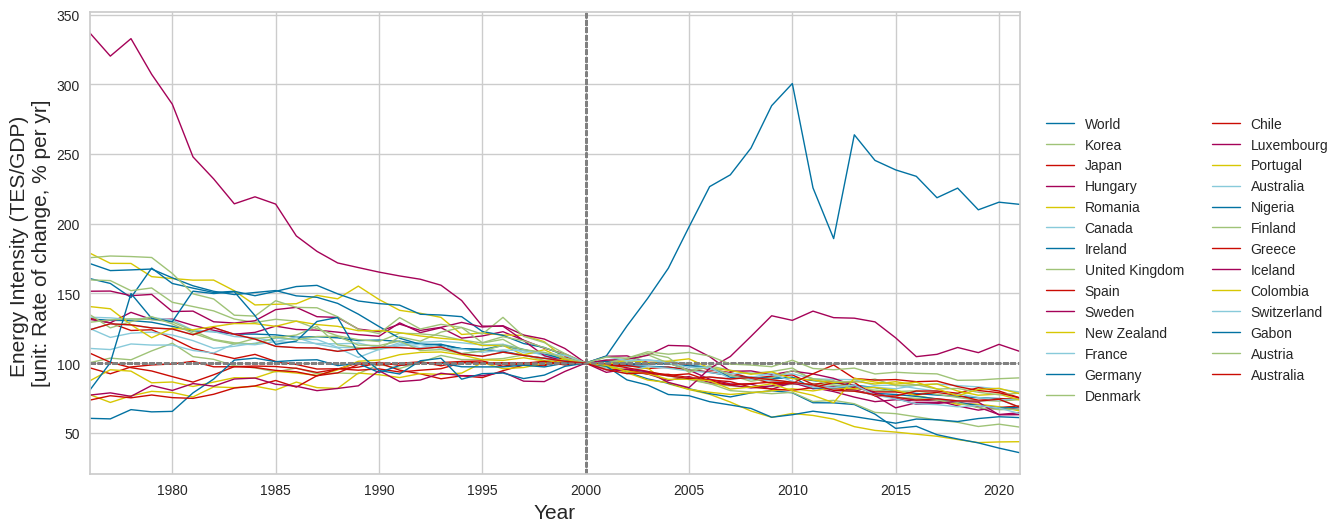

In [ ]:
year = 1976

# (4) Energy intensity (TES/GDP)

def energyint(country):
  x = pd.DataFrame(country["Energy intensity (TES/GDP)"])
  return x

fig, ax = plt.subplots(figsize=(12,6))
for i in range(len(legcountry)):
  ax.plot(energyint(legcountry[i].loc[year:]), label=legcountry_title[i], lw=1)
  ax.axhline(100, 0, 1, color="gray", linestyle="--", linewidth=1)
  ax.axvline(2000, 0, 1, color="gray", linestyle="--", linewidth=1)
  ax.set_xticks(iea_year[year:], minor=True)
  #ax.set_xticklabels(year, rotation=45)
  ax.legend(loc='upper center', bbox_to_anchor=(1.18, 0.8), ncol=2, fancybox=True, shadow=True)
  #ax.set_title("Energy Intensity of the Countries with Legally Binding Agreements (Reference year=2000)", fontsize=20, weight="bold")
  ax.set_ylabel("Energy Intensity (TES/GDP) \n[unit: Rate of change, % per yr]", fontsize=15)
  ax.set_xlabel("Year", fontsize=15)
plt.margins(x=0)
plt.show()
fig.savefig("ei_allc.png")
#files.download("ei_allc.png")

In [ ]:
# # Plot
# fig, ax = plt.subplots(figsize=(12,6))

# for i in range(len(legcountry)):
#     if legcountry_title[i] == "World":  # Highlight the "World" line
#         ax.plot(energyint(legcountry[i]), label=legcountry_title[i], color="red", lw=2, alpha=1)
#     else:
#         ax.plot(energyint(legcountry[i]), label=legcountry_title[i], lw=1, alpha=0.5)

# ax.axhline(100, 0, 1, color="gray", linestyle="--", linewidth=0.7)
# ax.axvline(2000, 0, 1, color="gray", linestyle="--", linewidth=0.7)

# ax.set_xticks(iea_year, minor=True)
# ax.legend(loc='upper center', bbox_to_anchor=(1.18, 0.8), ncol=2, fancybox=True, shadow=True)

# ax.set_ylabel("GDP per capita \n[unit: Rate of change, % per yr]", fontsize=15)
# ax.set_xlabel("Year", fontsize=15)

# plt.margins(x=0)
# plt.show()
# #fig.savefig("co2capita_allc.png")

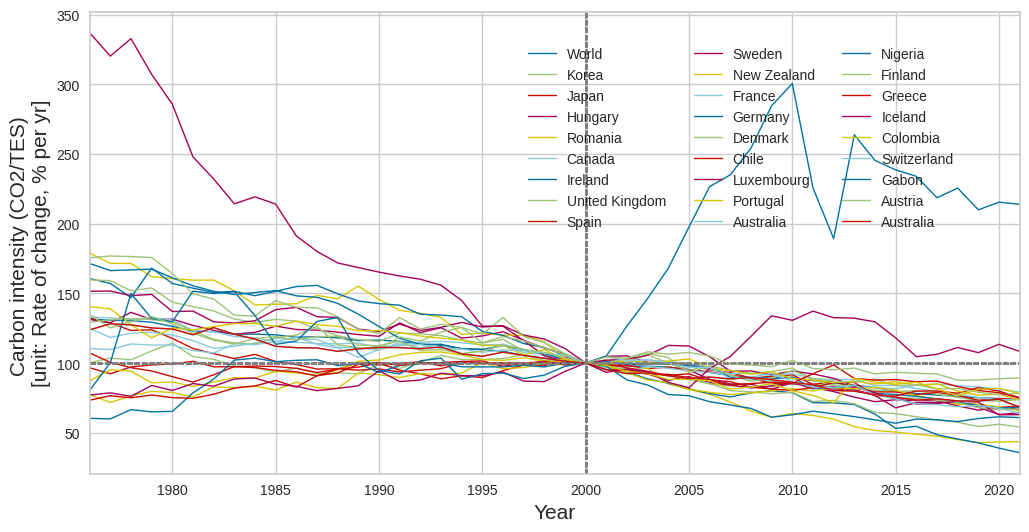

In [ ]:
# (5) Carbon intensity: ESCII (CO2/TES)

def carbonint(country):
  x = pd.DataFrame(country["Energy intensity (TES/GDP)"])
  return x

fig, ax = plt.subplots(figsize=(12,6))
for i in range(len(legcountry)):
  ax.plot(carbonint(legcountry[i].loc[year:]), label=legcountry_title[i], lw=1)
  ax.axhline(100, 0, 1, color="gray", linestyle="--", linewidth=1)
  ax.axvline(2000, 0, 1, color="gray", linestyle="--", linewidth=1)
  ax.set_xticks(iea_year[year:], minor=True)
  #ax.set_xticklabels(year, rotation=45)
  ax.legend(loc='upper center', bbox_to_anchor=(0.7, 0.95), ncol=3, fancybox=True, shadow=True)
  #ax.set_title("Carbon Intensity of the Countries with Legally Binding Agreements (Reference year=2000)", fontsize=20, weight="bold")
  ax.set_ylabel("Carbon intensity (CO2/TES) \n[unit: Rate of change, % per yr]", fontsize=15)
  ax.set_xlabel("Year", fontsize=15)
plt.margins(x=0)
plt.show()
fig.savefig("ci_allc.png")

In [ ]:
# # Plot
# fig, ax = plt.subplots(figsize=(12,6))

# for i in range(len(legcountry)):
#     if legcountry_title[i] == "World":  # Highlight the "World" line
#         ax.plot(carbonint(legcountry[i]), label=legcountry_title[i], color="red", lw=2, alpha=1)
#     else:
#         ax.plot(carbonint(legcountry[i]), label=legcountry_title[i], lw=1, alpha=0.5)

# ax.axhline(100, 0, 1, color="gray", linestyle="--", linewidth=0.7)
# ax.axvline(2000, 0, 1, color="gray", linestyle="--", linewidth=0.7)

# ax.set_xticks(iea_year, minor=True)
# ax.legend(loc='upper center', bbox_to_anchor=(1.18, 0.8), ncol=2, fancybox=True, shadow=True)

# ax.set_ylabel("GDP per capita \n[unit: Rate of change, % per yr]", fontsize=15)
# ax.set_xlabel("Year", fontsize=15)

# plt.margins(x=0)
# plt.show()
# #fig.savefig("co2capita_allc.png")

In [ ]:
#files.download("ci_allc.png")

# Time series Kmean cluster analysis

In [ ]:
# make co2emissions per capita columns for making dataframes
def co2capita_df(country):
  x = pd.DataFrame(country["CO2 emissions"] / country["Population"] * 100, columns=['CO2 emissions per capita'])
  return x

for i in range(len(legcountry)):
  legcountry[i]["CO2 emissions per capita"] = co2capita_df(legcountry[i])

# make dataframes for each factors

def make_col_df(col):
  df = pd.DataFrame()
  for i in range(len(legcountry)):
    df[legcountry_title[i]] = pd.DataFrame(legcountry[i][col]).rename(columns={"CO2 emissions per capita":legcountry_title[i]})
  return df

co2capita = make_col_df("CO2 emissions per capita")
gdpcapita = make_col_df("GDP per population (GDP per capita)")
energyin = make_col_df("Energy intensity (TES/GDP)")
carbonin = make_col_df("Carbon intensity: ESCII (CO2/TES)")

In [ ]:
# Feature engineering for cluster anlaysis

# - dataframe manipulation
co2capita_feat = co2capita.T.fillna(0).drop(labels=["World"])
gdpcapita_feat = gdpcapita.T.fillna(0).drop(labels=["World"])
energyin_feat = energyin.T.fillna(0).drop(labels=["World"])
carbonin_feat = carbonin.T.fillna(0).drop(labels=["World"])

# - make feature variable
df_feature = co2capita_feat
df_npy = np.array(df_feature)


name_npy = np.array(co2capita_feat.index) # variable for countries name
feature_npy = np.array(co2capita_feat) # variable for co2 per capita

def normalization_axis(feature):
  sum_npy = np.array([x/np.sum(x) for x in feature])
  return sum_npy

feature_norm_npy = normalization_axis(feature_npy)
feature_npy = np.array([np.array(x) for x in df_npy[:,1]])


# - feature engineering
co2_total = str(feature_norm_npy[~np.isnan(feature_norm_npy).any(axis=1)].shape[0])
print("co2 emissions per capita (number of countires): "+str(feature_norm_npy.shape[0]))
print("co2 emissions per capita (number of countries after erasing N/A): "+co2_total)

feature_norm = feature_norm_npy[~np.isnan(feature_norm_npy).any(axis=1)]
feature = feature_npy[~np.isnan(feature_norm_npy).any(axis=1)]
name = name_npy[~np.isnan(feature_norm_npy).any(axis=1)]

co2 emissions per capita (number of countires): 25
co2 emissions per capita (number of countries after erasing N/A): 25


<ipython-input-26-fbbd068a5bb1>:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  co2capita_feat = co2capita.T.fillna(0).drop(labels=["World"])
<ipython-input-26-fbbd068a5bb1>:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gdpcapita_feat = gdpcapita.T.fillna(0).drop(labels=["World"])
<ipython-input-26-fbbd068a5bb1>:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_sil

##Elbow method to determine number of clusters

In [ ]:
dir = "/content/drive/MyDrive/1. Research Experience/Paper_Scenario/figures/"

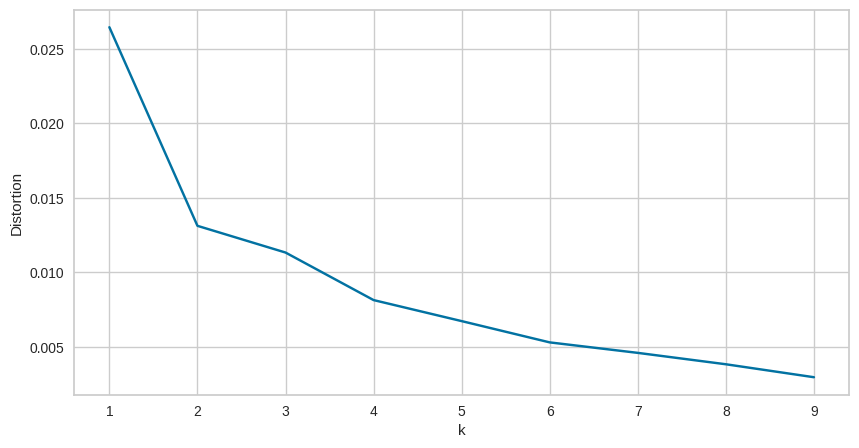

In [ ]:
distortions = []
K = range(1,10)

for k in K:
  kmeanModel = KMeans(n_clusters=k)
  kmeanModel.fit(feature_norm)
  distortions.append(kmeanModel.inertia_)

fig, ax = plt.subplots(figsize=[10,5])
ax.plot(K, distortions, 'bx-')
ax.set_xlabel('k')
ax.set_ylabel('Distortion')
#ax.set_title('The Elbow Method showing the optimal k')
fig.show()

fig.savefig(dir+"Fig2_1" + ".pdf", bbox_inches='tight')

In [ ]:
files.download("Fig3_elbow_org.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Elbow method: https://www.scikit-yb.org/en/latest/api/cluster/elbow.html

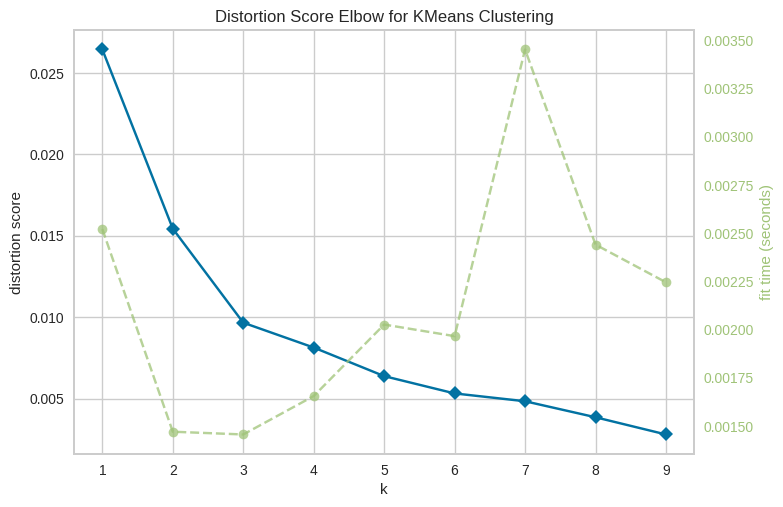

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10), locate_elbow=False)

X = feature_norm
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()

In [ ]:
!pip install yellowbrick

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

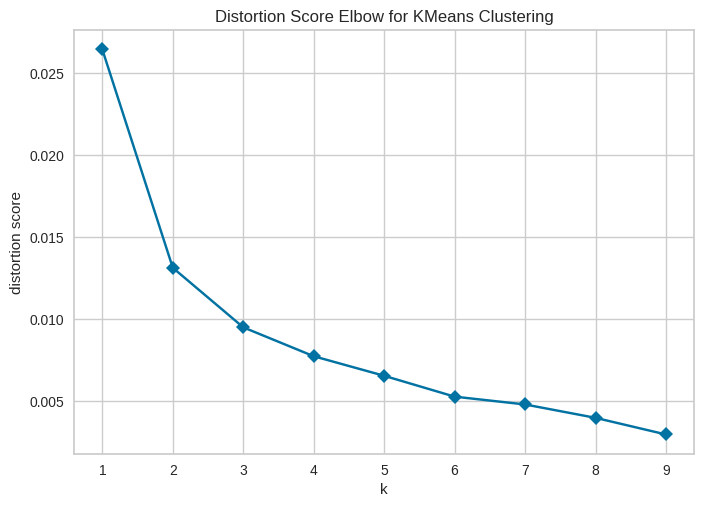

In [ ]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10), timings=False, locate_elbow=False, title=False)

X = feature_norm
visualizer.fit(X)
#visualizer.fig.suptitle("")
visualizer.show()

#fig.savefig(dir+"Fig2_1" + ".pdf", bbox_inches='tight')

In [ ]:
visualizer.show(outpath="elbow_plot.png")

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# # Fit KMeans with the desired number of clusters (for example, k=3)
# model = KMeans(n_clusters=3, random_state=42)
# model.fit(X)

# Predict the cluster labels for X
cluster_labels = model.predict(X)

# Calculate the silhouette score
sil_score = silhouette_score(X, cluster_labels)

# Print silhouette score
print(f'Silhouette Score for k=3: {sil_score}')

# If you want to evaluate silhouette score across multiple values of k,
# you can do the following:

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    score = silhouette_score(X, cluster_labels)
    silhouette_scores.append(score)
    print(f'Silhouette Score for k={n_clusters}: {score}')

# Plotting silhouette scores for different values of k
plt.figure()
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.show()


##Kmeans clustering results


Through hyperparameter tuning, this study determined that it was appropriate to classify into four clusters.

In [ ]:
# Kmean Clustering

# - Set number of clusters
n_cluster = 3
km = TimeSeriesKMeans(n_clusters = n_cluster, metric="euclidean", max_iter=150).fit(feature_norm)
rlt_tsm = km.predict(feature_norm)

# - Labeling
labels = []
sizes = []
for i in range(n_cluster):
  labels.append("cluster_"+str(1+i))
  sizes.append(collections.Counter(rlt_tsm)[i])

Note that the cluster positions are always changed whenver running the codes.

In [ ]:
plt.figure(figsize=(10,5))
plt.pie(sizes, labels=labels, shadow=True, startangle=90, autopct="%1.1f%%")
plt.title("Cluster Distribution \n(Number of countries:" +co2_total+")", position=(0.5,1.2), fontsize=20)
plt.show()

In [ ]:
# Run PCA to review how cluster is doing well

fig, ax = plt.subplots()

pca = PCA(n_components=2)
rlt_pca = pca.fit_transform(feature_norm_npy[~np.isnan(feature_norm_npy).any(axis=1)])
for i in range(n_cluster):
  label_name = "Cluster " +str(1+i)
  ax.scatter(rlt_pca[:,0][rlt_tsm==i],rlt_pca[:,1][rlt_tsm==i],label=label_name)
ax.legend(loc='upper center', bbox_to_anchor=(1.1, 0.8), ncol=1, fancybox=True, shadow=True)

#fig.savefig(dir+"Fig2" + ".pdf", bbox_inches='tight')

In [ ]:
#files.download("Fig4_K_org.png")

In [ ]:
# Make function for plotting
def show_cluster_dist(num_cluster,num_sample=50):
  fig, ax = plt.subplots(figsize=(15,5))
  size = sizes[num_cluster]
  if(size>num_sample):
    size = num_sample
  for i in range(size):
    name = "cluster" + str(i)
    year = [x for x in co2capita_feat.columns.astype(str)]
    plt.plot(year, feature_norm[rlt_tsm==num_cluster][i])
  #plt.axvline(10, color='red',label='Base year(2000)',linewidth=1)
  #plt.axvspan(5.8, 9.5, color='red', alpha=0.2)
  plt.xlabel("Year", fontsize=15)
  plt.xticks(rotation=90)
  plt.ylabel("Rate of change [% per year]", fontsize=15)
  #plt.title("Changes in CO2 emission per capita",fontsize=20)
  plt.legend(name_npy[rlt_tsm == num_cluster], loc='upper center', bbox_to_anchor=(1.06, 0.8), ncol=1, fancybox=True, shadow=True)
  plt.show()

  fig.savefig(dir+"show_cluster_dist" + str(num_cluster) + ".pdf", bbox_inches='tight')
  #files.download("show_cluster_dist"+str(num_cluster)+ ".pdf")

In [ ]:
# Make function for plotting
def show_cluster_dist(num_cluster,num_sample=50):
  fig, ax = plt.subplots(figsize=(15,5))
  size = sizes[num_cluster]
  if(size>num_sample):
    size = num_sample
  for i in range(size):
    name = "cluster" + str(i)
    year = [x for x in co2capita_feat.columns.astype(str)]
    plt.plot(year, feature_norm[rlt_tsm==num_cluster][i])
  #plt.axvline(10, color='red',label='Base year(2000)',linewidth=1)
  #plt.axvspan(5.8, 9.5, color='red', alpha=0.2)
  plt.xlabel("Year", fontsize=15)
  plt.xticks(rotation=90)
  plt.ylabel("Rate of change [% per year]", fontsize=15)
  #plt.title("Changes in CO2 emission per capita",fontsize=20)
  plt.legend(name_npy[rlt_tsm == num_cluster], loc='upper center', bbox_to_anchor=(1.1, 0.8), ncol=1, fancybox=True, shadow=True)
  plt.show()

  fig.savefig(dir+"show_cluster_dist"+str(num_cluster)+ ".pdf", bbox_inches='tight')
  #files.download("show_cluster_dist"+str(num_cluster)+".pdf")

In [ ]:
num_cluster=3
for i in range(num_cluster):
  show_cluster_dist(i)

# Statistics of Kaya Identity factors by Country

Period-wide analysis of change in GHG emission per capita, 2000-2022

In [ ]:
# legcountry_title = ['Iceland', 'Denmark', 'Gabon', 'Sweden', 'Hungary', 'France', 'Germany', 'Switzerland', 'Luxembourg',
#                     'United Kingdom', 'Romania', 'Finland', 'Greece', 'Autria', 'New Zealand', 'Colombia', 'Portugal',
#                     'Canada', 'Spain', 'Japan', 'Australia', 'Ireland', 'Chile', 'South Korea', 'Nigeria', 'European Union', 'World']

legcountry_title = ['World', 'European Union', 'Nigeria', 'South Korea', 'Chile', 'Ireland', 'Australia','Japan','Spain', 'Canada',
                    'Portugal', 'Colombia', 'New Zealand', 'Austria', 'Greece', 'Finland', 'Romania', 'United Kingdom',
                    'Luxembourg', 'Switzerland', 'Germany', 'France', 'Hungary', 'Sweden', 'Gabon', 'Denmark', 'Ireland']

   #['World', 'Korea','Japan','Hungary','Romania','Canada','Ireland','United Kingdom','Spain','Sweden','New Zealand','France','Germany','Denmark','Chile','Luxembourg',
   #                 'Portugal','Australia','Nigeria','Finland','Greece','Iceland','Colombia','Switzerland','Gabon','Austria','Australia']

In [ ]:
# - Data manipulation
def make_CV(country):
  cols = [world.columns[5], world.columns[2], world.columns[3], world.columns[4]]
  new_df = country.loc[range(2000, country.index[-1]+1),:][cols] -100
  return new_df

# -- Make Dataframe for the recent year (2020) - CV for different factors of GHG emissions
world_new = make_CV(world)
korea_new = make_CV(korea)
japan_new = make_CV(japan)
hungary_new = make_CV(hungary)
romania_new = make_CV(romania)
canada_new = make_CV(canada)
ireland_new = make_CV(ireland)
uk_new = make_CV(uk)
spain_new = make_CV(spain)
sweden_new = make_CV(sweden)
nz_new = make_CV(nz)
france_new = make_CV(france)
germany_new = make_CV(germany)
denmark_new = make_CV(denmark)
#eu_new = make_CV(eu)
chile_new = make_CV(chile)
luxembourg_new = make_CV(luxembourg)
portugal_new = make_CV(portugal)
australia_new = make_CV(australia)
nigeria_new = make_CV(nigeria)
finland_new = make_CV(finland)
greece_new = make_CV(greece)
iceland_new = make_CV(iceland)
colombia_new = make_CV(colombia)
switzerland_new = make_CV(switzerland)
gabon_new = make_CV(gabon)
austria_new = make_CV(austria)



# legcountry_cv = [iceland_new, denmark_new,gabon_new,sweden_new,hungary_new,france_new, germany_new, switzerland_new, luxembourg_new,
#                  uk_new, romania_new, finland_new, greece_new, austria_new, nz_new, colombia_new, portugal_new,
#                  canada_new, spain_new, japan_new, australia_new, ireland_new, chile_new, korea_new, nigeria_new, world_new]

legcountry_cv = [world_new, nigeria_new, korea_new, chile_new, ireland_new, australia_new, japan_new, spain_new, canada_new,
                 portugal_new, colombia_new, nz_new, austria_new, greece_new, finland_new, romania_new, uk_new,
                 luxembourg_new, switzerland_new, germany_new, france_new, hungary_new, sweden_new, gabon_new, denmark_new, ireland_new]

# legcountry_cv = [world_new, korea_new,japan_new,hungary_new,romania_new,canada_new,
#                  ireland_new, uk_new, spain_new, sweden_new, nz_new, france_new,
#                  germany_new, denmark_new, chile_new, luxembourg_new,
#                  portugal_new, australia_new, nigeria_new, finland_new,
#                  greece_new, iceland_new, colombia_new, switzerland_new,
#                  gabon_new, austria_new]

In [ ]:
# year = 2021
# col = "CO2 emissions per capita"
# for i in range(len(legcountry_cv)):
#   print(round(legcountry_cv[i].loc[year][col], 1))

In [ ]:
# -- Make Equation

# Mean
mean = lambda x: np.mean(x)
# std (Standard Deviation)
std = lambda x: np.std(x, ddof=1)
# CV
cv = lambda x: np.std(x, ddof=1) / np.mean(x) * 100

year = korea_new.index[-1]
# delta G = GDP per capita
delta_G = korea_new['GDP per population (GDP per capita)'].loc[year] - korea_new['GDP per population (GDP per capita)'].loc[2000]
# delta_I = emission intensity (energy use per GDP)
delta_I = korea_new['Energy intensity (TES/GDP)'].loc[year] - korea_new['Energy intensity (TES/GDP)'].loc[2000]
# delta_F = carbon intensity (carbon emission per energy use)
delta_F = korea_new['Carbon intensity: ESCII (CO2/TES)'].loc[year] - korea_new['Carbon intensity: ESCII (CO2/TES)'].loc[2000]

In [ ]:
def make_cv_df(origindf):
  new_df = pd.DataFrame()
  dft = origindf.loc[2000:].T
  styear = 2000
  enyear = origindf.index[-1]

  new_df["2021Values"] = dft[enyear]
  new_df["Rate_of_growth"] = (dft[enyear] - dft[styear])/(enyear-styear)
  new_df["Mean"] = origindf.loc[styear:].mean()
  new_df["STD"] = origindf.loc[styear:].std()
  new_df["CV"] = (origindf.loc[styear:].std()/origindf.loc[styear:].mean())*100
  return new_df

In [ ]:
# -- GHG emission factor - 	CO2 emissions
co2_cv = make_cv_df(make_col_df("CO2 emissions"))
# -- CO2capita
co2ca_cv = make_cv_df(make_col_df("CO2 emissions per capita"))
# -- GDP per capita - GDP per population (GDP per capita)
gdpca_cv = make_cv_df(make_col_df("GDP per population (GDP per capita)"))
# -- Energy intensity - Energy intensity (TES/GDP)
energyin_cv = make_cv_df(make_col_df("Energy intensity (TES/GDP)"))
# -- Carbon intensity - Carbon intensity: ESCII (CO2/TES)
carbonin_cv = make_cv_df(make_col_df("Carbon intensity: ESCII (CO2/TES)"))

In [ ]:
allcv = pd.concat([co2_cv, co2ca_cv, gdpca_cv, energyin_cv, carbonin_cv], axis=1)
allcv.to_excel('allcv.xlsx')
allcv

In [ ]:
allcv["Rate_of_growth"]

In [ ]:
allcv["CV"].iloc[:,1:].round(2)

In [ ]:
#files.download('allcv.xlsx')

In [ ]:
year = 2021

# Period-wise analysis of change in CO2 emission per capita, 2000-2021
fig, ax = plt.subplots(figsize=(8,8))
ax.barh('World', korea_new['GDP per population (GDP per capita)'].loc[year], color= "tab:blue", label="GDP per population (ΔG)")
ax.barh('World', korea_new['Energy intensity (TES/GDP)'].loc[year], color="tab:orange", label="Energy intensity (ΔI)")
ax.barh('World', korea_new['Carbon intensity: ESCII (CO2/TES)'].loc[year], color="tab:green", label="Carbon intensity (ΔF)")

for i in range(len(legcountry_cv)):

  ax.barh(legcountry_title[i], legcountry_cv[i]['GDP per population (GDP per capita)'].loc[year], color="tab:blue", alpha=0.7)
  ax.barh(legcountry_title[i], legcountry_cv[i]['Energy intensity (TES/GDP)'].loc[year], color="tab:orange", alpha=0.7)
  ax.barh(legcountry_title[i], legcountry_cv[i]['Carbon intensity: ESCII (CO2/TES)'].loc[year], color="tab:green", alpha=0.7)

  # ax.axvline(0, 0, 1, color="black", linestyle="--", linewidth=1)
  # ax.axhline("World", 0, 1, color="black", linestyle="--", linewidth=1)

  ax.legend(fontsize=10, loc='upper right', ncol=1, fancybox=True, shadow=True)
  ax.set_xlabel("Δ (CO2 emissions/P)", fontsize=15)
  #ax.set_ylabel("Carbon Neutrality Legalized Countries", fontsize=15)
  #ax.set_ylabel("CO2 emissions per capita (Ascending order)", fontsize=15)
  #ax.set_title("Period-wise analysis of change in CO2 emission per capita, 2000-2020 \n for countries in descending order by mean of CO2 emission per capita", fontsize=20, weight="bold")

plt.show()

fig.savefig("period.png")

In [ ]:
files.download("period.png")

# Index Decomposition Analysis (IDA)
- Decomposition of CO2 emissions per capita change in countries

Period-wide analysis of change in decomposition of CO2 emissions by three factors(CO2 emissions per capita, energy intensity, carbon intensity) or four factors (CO2 emissions, population, energy intensity, carbon intensity).

In [ ]:
# Decomposition of CO2 emissions per capita change in Korea
world_new = world.loc[range(world.index[0], world.index[-1]+1),:][["CO2 emissions per capita",
                                            "GDP per population (GDP per capita)",
                                            "Energy intensity (TES/GDP)",
                                            "Carbon intensity: ESCII (CO2/TES)",
                                            "CO2 emissions", "Population"]] -100
year = world_new.index.to_list()

# Plot
fig, ax = plt.subplots(figsize=(30,7))

ax.plot(world_new["CO2 emissions"],'o--', label="CO2 emissions", c="purple")
ax.plot(world_new["CO2 emissions per capita"], 'x--', c="purple", label="CO2 emissions per capita(Δ(GHG/P))")
ax.bar(year, world_new["GDP per population (GDP per capita)"], label="GDP per capita (ΔG)", color="tab:blue")
ax.bar(year, world_new["Population"], label="Population", color="tab:red")
ax.bar(year, world_new["Energy intensity (TES/GDP)"], label="Energy intensity (ΔI)", color="tab:orange")
ax.bar(year, world_new["Carbon intensity: ESCII (CO2/TES)"], label="Carbon intensity (ΔF)", color="tab:green")

ax.set_xticks(year)
#ax.set_xticklabels(world2020_year, rotation=90)

ax.legend()
ax.set_xlabel("Year", fontsize=15)
ax.set_ylabel("Rate of change [% per year]", fontsize=15)
ax.set_title("World", fontsize=20, loc="right")
ax.axhline(0, 0, 1, color="lightgray", linestyle="--", linewidth=2)

plt.show()

#fig.savefig("dec_world.png")

In [ ]:
# - Make dataframe
collist = ["CO2 emissions per capita", "GDP per population (GDP per capita)", "Energy intensity (TES/GDP)",
           "Carbon intensity: ESCII (CO2/TES)", "CO2 emissions", "Population"]
new_range= range(2001, world.index[-1]+1)

def country_plot(country, title):

  # - Make parameters
  year = country.index.to_list()
  co2em = country["CO2 emissions"]
  co2emcapita = country["CO2 emissions per capita"]
  gdppercap = country["GDP per population (GDP per capita)"]
  energyint = country["Energy intensity (TES/GDP)"]
  pop = country["Population"]
  carbonint = country["Carbon intensity: ESCII (CO2/TES)"]

  # - Plot
  fig, ax = plt.subplots(figsize=(15,7))
  ax.plot(co2em,'o--', label="CO2 emissions", c="purple")
  ax.plot(co2emcapita,'x--', c="purple", label="CO2 emissions per capita")
  ax.bar(year, gdppercap, label="GDP per capita (ΔG)", color="tab:blue")
  ax.bar(year, energyint, label="Energy intensity (ΔI)", color="tab:orange")
  ax.bar(year, pop, label="Population", color="tab:red")
  ax.bar(year, carbonint, label="Carbon intensity (ΔF)", color="tab:green")

  ax.set_xticks(year)
  ax.legend()
  ax.set_xlabel("Year", fontsize=15)
  ax.set_ylabel("Rate of change [% per year]", fontsize=15)
  ax.set_title(title, fontsize=20, loc="right")
  ax.axhline(0, 0, 1, color="lightgray", linestyle="--", linewidth=2)

  plt.show()

  fig.savefig("dec_"+title+".png")


In [ ]:
#country_plot(country = world.loc[new_range,:][collist] -100, title="World")

In [ ]:
# files.download("dec_"+title+".png")

## CO2 emissions-increasing Group

In [ ]:
#country_plot(country = korea.loc[new_range,:][collist] -100, title = "South Korea")

In [ ]:
#country_plot(country = chile.loc[new_range,:][collist] -100, title = "Chile")

## Multiplots

In [ ]:
# - Make dataframe
collist = ["CO2 emissions per capita", "GDP per population (GDP per capita)", "Energy intensity (TES/GDP)",
           "Carbon intensity: ESCII (CO2/TES)", "CO2 emissions", "Population"]
new_range= range(2001, world.index[-1]+1)

def country_plot(country, title):

  # - Make parameters
  year = country.index.to_list()
  co2em = country["CO2 emissions"]
  co2emcapita = country["CO2 emissions per capita"]
  gdppercap = country["GDP per population (GDP per capita)"]
  energyint = country["Energy intensity (TES/GDP)"]
  pop = country["Population"]
  carbonint = country["Carbon intensity: ESCII (CO2/TES)"]

  # - Plot
  fig, ax = plt.subplots(figsize=(15,7))
  ax.plot(co2em,'o--', label="CO2 emissions", c="purple")
  ax.plot(co2emcapita,'x--', c="purple", label="CO2 emissions per capita")
  ax.bar(year, gdppercap, label="GDP per capita (ΔG)", color="tab:blue")
  ax.bar(year, energyint, label="Energy intensity (ΔI)", color="tab:orange")
  ax.bar(year, pop, label="Population", color="tab:red")
  ax.bar(year, carbonint, label="Carbon intensity (ΔF)", color="tab:green")

  ax.set_xticks(year)
  ax.legend()
  ax.set_xlabel("Year", fontsize=15)
  ax.set_ylabel("Rate of change [% per year]", fontsize=15)
  ax.set_title(title, fontsize=20, loc="right")
  ax.axhline(0, 0, 1, color="lightgray", linestyle="--", linewidth=2)

  plt.show()

  fig.savefig("dec_"+title+".png")

  files.download("dec_"+title+".png")

In [ ]:
def country_new(country):
  country_new = country.loc[range(2001, korea.index[-1]+1),:][["CO2 emissions per capita",
                                                 "GDP per population (GDP per capita)",
                                                 "Energy intensity (TES/GDP)",
                                                 "Carbon intensity: ESCII (CO2/TES)",
                                                 "CO2 emissions", "Population"]] -100
  year = country_new.index.to_list()
  return country_new, year

In [ ]:
# Original style
colors = {
    'gdp': '#1b9e77',               # Dark Blue-Green
    'energy_intensity': '#d95f02',  # Orange
    'population': '#7570b3',        # Purple-Blue
    'carbon_intensity': '#66a61e',  # Olive Green
    'co2': '#984ea3',               # Purple
    'co2_per_capita': '#ff7f00'     # Orange (different shade for dashed line)
}

In [ ]:
#Paul Tol's Safe Colors:

colors = {
    'gdp': '#332288',
    'energy_intensity':  '#CC6677',
    'population': '#117733',
    'carbon_intensity':  '#AA4499',
    'co2': '#44AA99',
    'co2_per_capita':'#DDCC77'
}

In [ ]:
# journal article st

colors = {
    'gdp': '#cecece',
    'energy_intensity': '#a559aa',
    'population': '#59a89c',
    'carbon_intensity': '#f0c571',
    'co2': '#e02b35',
    'co2_per_capita': '#082a54'
}

In [ ]:
# Updated color dictionary for journal article
colors = {
    'energy_intensity': '#a559aa',      # Bottom (purple)
    'carbon_intensity': '#f0c571',      # 2nd (gold)
    'population': '#59a89c',            # 3rd (teal-green)
    'gdp': '#cecece',                   # Top (light gray)

    'co2': '#e02b35',                   # Line (red, solid)
    'co2_per_capita': '#082a54'        # Line (navy, dashed)
}

In [ ]:
korea_new, year = country_new(korea)
chile_new, year = country_new(chile)
nigeria_new, year = country_new(nigeria)

group = [korea_new, chile_new, nigeria_new]
title = ["South Korea", "Chile", "Nigeria"]

r,c = 1,3

# - Plot
fig, ax = plt.subplots(r,c,figsize=(14,4), sharex=True, sharey=True)

n=0
ax[0].plot(group[n]["CO2 emissions"],'--', label="CO2 emissions", color=colors['co2'], markersize=0.2)
ax[0].plot(group[n]["CO2 emissions per capita"],'--', label="CO2 emissions per capita", color=colors['co2_per_capita'])
ax[0].bar(year, group[n]["GDP per population (GDP per capita)"], label="GDP per capita (ΔG)", color=colors['gdp'])
ax[0].bar(year, group[n]["Energy intensity (TES/GDP)"], label="Energy intensity (ΔI)", color=colors['energy_intensity'])
ax[0].bar(year, group[n]["Population"], label="Population", color=colors['population'], alpha=0.8)
ax[0].bar(year, group[n]["Carbon intensity: ESCII (CO2/TES)"], label="Carbon intensity (ΔF)", color=colors['carbon_intensity'])
#ax[0,0].legend(name_npy[rlt_tsm == num_cluster], loc='upper center', bbox_to_anchor=(0, 0), ncol=1, fancybox=True, shadow=True)
#ax[0,0].legend(name_npy[rlt_tsm == num_cluster], loc='upper center', bbox_to_anchor=(1.1, 1.0), ncol=1, fancybox=True, shadow=True)
ax[0].legend()

for i in range(len(group)):
  ax[i].plot(group[i]["CO2 emissions"],'--',c=colors['co2'])
  ax[i].plot(group[i]["CO2 emissions per capita"],'--', c=colors['co2_per_capita'])
  ax[i].bar(year, group[i]["GDP per population (GDP per capita)"],color=colors['gdp'], alpha=0.8)
  ax[i].bar(year, group[i]["Energy intensity (TES/GDP)"], color=colors['energy_intensity'], alpha=0.8)
  ax[i].bar(year, group[i]["Population"], color=colors['population'], alpha=0.8)
  ax[i].bar(year, group[i]["Carbon intensity: ESCII (CO2/TES)"], color=colors['carbon_intensity'], alpha=0.8)

  tick_spacing = 5
  ax[i].set_xticks(year)
  #ax[i//c,i%c].set_xticklabels(df.columns,rotation = 90)
  ax[i].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
  #ax[i].set_xlabel("Year", fontsize=15)
  #ax[i//c,i%c].set_ylabel("Rate of change \n[% per year]", fontsize=15)
  ax[i].set_title(title[i], fontsize=15, loc="center")
  ax[i].axhline(0, 0, 1, color="lightgray", linestyle="--", linewidth=2)

  #ax[r-1,c-1].axis('off')

#fig.savefig("ida_inc.png")

fig.supxlabel("Year")
fig.supylabel("% change (Base year = 2000)")
fig.tight_layout()

fig.savefig(dir+"Fig8"+".pdf", bbox_inches='tight')

plt.show()

In [ ]:
#files.download("ida_inc.png")

## Decreasing CO2 emissions per capita (Hungary, Romania, United Kingdom, Sweden, France, Germany, Denmark)

In [ ]:
hungary_new, year = country_new(hungary)
romania_new, year = country_new(romania)
uk_new, year = country_new(uk)
sweden_new, year = country_new(sweden)
france_new, year = country_new(france)
germany_new, year = country_new(germany)
denmark_new, year = country_new(denmark)
luxembourg_new, year = country_new(luxembourg)
iceland_new, year = country_new(iceland)
switzerland_new, year = country_new(switzerland)
gabon_new, year = country_new(gabon)

group = [hungary_new, romania_new, uk_new, sweden_new, france_new, germany_new, denmark_new,
             luxembourg_new, iceland_new, switzerland_new, gabon_new]
title = ["Hungary", "Romania", "United Kingdom", "Sweden", "France", "Germany", "Denmark",
             "Luxembourg", "Iceland", "Switzerland", "Gabon"]

r,c =3,4

# - Plot
fig, ax = plt.subplots(r,c,figsize=(15,10), sharex=True, sharey=True)

n=0
ax[0,0].plot(group[n]["CO2 emissions"],'--', label="CO2 emissions", color=colors['co2'], markersize=0.2)
ax[0,0].plot(group[n]["CO2 emissions per capita"],'--', label="CO2 emissions per capita", color=colors['co2_per_capita'])
ax[0,0].bar(year, group[n]["GDP per population (GDP per capita)"], label="GDP per capita (ΔG)", color=colors['gdp'])
ax[0,0].bar(year, group[n]["Energy intensity (TES/GDP)"], label="Energy intensity (ΔI)", color=colors['energy_intensity'])
ax[0,0].bar(year, group[n]["Population"], label="Population", color=colors['population'])
ax[0,0].bar(year, group[n]["Carbon intensity: ESCII (CO2/TES)"], label="Carbon intensity (ΔF)", color=colors['carbon_intensity'])
#ax[0,0].legend(name_npy[rlt_tsm == num_cluster], loc='upper center', bbox_to_anchor=(0, 0), ncol=1, fancybox=True, shadow=True)
#ax[0,0].legend(name_npy[rlt_tsm == num_cluster], loc='upper center', bbox_to_anchor=(0.9, 0.8), ncol=1, fancybox=True, shadow=True)
ax[0,0].legend(loc="upper left")

for i in range(len(group)):
  ax[i//c,i%c].plot(group[i]["CO2 emissions"],'--',color=colors['co2'])
  ax[i//c,i%c].plot(group[i]["CO2 emissions per capita"],'--', color=colors['co2_per_capita'])
  ax[i//c,i%c].bar(year, group[i]["GDP per population (GDP per capita)"],color=colors['gdp'])
  ax[i//c,i%c].bar(year, group[i]["Energy intensity (TES/GDP)"], color=colors['energy_intensity'])
  ax[i//c,i%c].bar(year, group[i]["Population"], color=colors['population'])
  ax[i//c,i%c].bar(year, group[i]["Carbon intensity: ESCII (CO2/TES)"], color=colors['carbon_intensity'])

  tick_spacing = 5
  ax[i//c,i%c].set_xticks(year)
  #ax[i//c,i%c].set_xticklabels(df.columns,rotation = 90)
  ax[i//c,i%c].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
  #ax[i].set_xlabel("Year", fontsize=15)
  #ax[i//c,i%c].set_ylabel("Rate of change \n[% per year]", fontsize=15)
  ax[i//c,i%c].set_title(title[i], fontsize=15, loc="center")
  ax[i//c,i%c].axhline(0, 0, 1, color="lightgray", linestyle="--", linewidth=2)

  ax[r-1,c-1].axis('off')

fig.supxlabel("Year")
fig.supylabel("% change (Base year = 2000)")
fig.tight_layout()

fig.savefig(dir+"Fig6"+".pdf", bbox_inches='tight')

plt.show()

## U-shaped CO2 emissions per capita (Japan, Canada, Ireland, Spain, New Zealand)

In [ ]:
japan_new, year = country_new(japan)
canada_new, year = country_new(canada)
ireland_new, year = country_new(ireland)
spain_new, year = country_new(spain)
nz_new, year = country_new(nz)
portugal_new, year = country_new(portugal)
australia_new, year = country_new(australia)
finland_new, year = country_new(finland)
greece_new, year = country_new(greece)
colombia_new, year = country_new(colombia)
austria_new, year = country_new(austria)

group = [japan_new, canada_new, ireland_new, spain_new, nz_new, portugal_new, australia_new, finland_new, greece_new, colombia_new, austria_new]
title = ["Japan", "Canada", "Ireland", "Spain", "New Zealand",
         "Portugal", "Australia", "Finland", "Greece",
         "Colombia", "Austria"]

r,c =3,4

# - Plot
fig, ax = plt.subplots(r,c,figsize=(15,10), sharex=True, sharey=True)

n=0
ax[0,0].plot(group[n]["CO2 emissions"],'--', label="CO2 emissions", color=colors['co2'], markersize=0.2)
ax[0,0].plot(group[n]["CO2 emissions per capita"],'--', label="CO2 emissions per capita", color=colors['co2_per_capita'])
ax[0,0].bar(year, group[n]["GDP per population (GDP per capita)"], label="GDP per capita (ΔG)", color=colors['gdp'])
ax[0,0].bar(year, group[n]["Energy intensity (TES/GDP)"], label="Energy intensity (ΔI)", color=colors['energy_intensity'])
ax[0,0].bar(year, group[n]["Population"], label="Population", color=colors['population'])
ax[0,0].bar(year, group[n]["Carbon intensity: ESCII (CO2/TES)"], label="Carbon intensity (ΔF)", color=colors['carbon_intensity'])
ax[0,0].legend(loc="upper left")

for i in range(len(group)):
  ax[i//c,i%c].plot(group[i]["CO2 emissions"],'--', color=colors['co2'])
  ax[i//c,i%c].plot(group[i]["CO2 emissions per capita"],'--', color=colors['co2_per_capita'])
  ax[i//c,i%c].bar(year, group[i]["GDP per population (GDP per capita)"], color=colors['gdp'])
  ax[i//c,i%c].bar(year, group[i]["Energy intensity (TES/GDP)"], color=colors['energy_intensity'])
  ax[i//c,i%c].bar(year, group[i]["Population"], color=colors['population'])
  ax[i//c,i%c].bar(year, group[i]["Carbon intensity: ESCII (CO2/TES)"], color=colors['carbon_intensity'])

  tick_spacing = 5
  ax[i//c,i%c].set_xticks(year)
  #ax[i//c,i%c].set_xticklabels(df.columns,rotation = 90)
  ax[i//c,i%c].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
  #ax[i].set_xlabel("Year", fontsize=15)
  #ax[i//c,i%c].set_ylabel("Rate of change \n[% per year]", fontsize=15)
  ax[i//c,i%c].set_title(title[i], fontsize=15, loc="center")
  ax[i//c,i%c].axhline(0, 0, 1, color="lightgray", linestyle="--", linewidth=2)

  ax[r-1,c-1].axis('off')

fig.supxlabel("Year")
fig.supylabel("% change (Base year = 2000)")
fig.tight_layout()

fig.savefig(dir+"Fig7"+".pdf", bbox_inches='tight')

plt.show()